Import necessary library 

In [6]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



In [7]:
#load the CIFAR-10 dataset and split it with train and test
(trainX, trainy), (testX, testy) = cifar10.load_data()

Scaling the pixel values train data and One-hot encoding the labels like test

In [8]:
# preprocess the data
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

num_classes = 10 # we have 10 different labels to differentiate the images
trainy = np.eye(num_classes)[trainy.reshape(-1)]
testy = np.eye(num_classes)[testy.reshape(-1)]

In [9]:
print(trainX.shape)
print(trainy.shape)

(50000, 32, 32, 3)
(50000, 10)


In [10]:
trainX, valX = trainX[:40000], trainX[10000:]
trainy, valy = trainy[:40000], trainy[10000:]

Building fully connected layers

In [11]:
# define the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=trainX.shape[1:]))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Compile the given model by using optimizer

In [12]:
# compile the model by decreasing the learning curve
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

filt model with train portion for 10 epochs

In [13]:
# train the model
model.fit(trainX, trainy, batch_size=18, epochs=14, validation_data=(testX, testy))


Epoch 1/14
2223/2223 [==============================] - 185s 82ms/step - loss: 1.6733 - accuracy: 0.3814 - val_loss: 1.3640 - val_accuracy: 0.5018
Epoch 2/14
2223/2223 [==============================] - 182s 82ms/step - loss: 1.3573 - accuracy: 0.5094 - val_loss: 1.2128 - val_accuracy: 0.5647
Epoch 3/14
2223/2223 [==============================] - 183s 82ms/step - loss: 1.2391 - accuracy: 0.5595 - val_loss: 1.1525 - val_accuracy: 0.5869
Epoch 4/14
2223/2223 [==============================] - 183s 82ms/step - loss: 1.1607 - accuracy: 0.5874 - val_loss: 1.0587 - val_accuracy: 0.6306
Epoch 5/14
2223/2223 [==============================] - 181s 81ms/step - loss: 1.1131 - accuracy: 0.6043 - val_loss: 0.9808 - val_accuracy: 0.6531
Epoch 6/14
2223/2223 [==============================] - 183s 82ms/step - loss: 1.0623 - accuracy: 0.6235 - val_loss: 0.9577 - val_accuracy: 0.6636
Epoch 7/14
2223/2223 [==============================] - 181s 81ms/step - loss: 1.0291 - accuracy: 0.6387 - val_loss: 0

featureExtractor model to extract features from the fully connected layer for both the training set trainX and the test set testX. 

In [14]:
# extract features from the fully connected layer before the output layer
from tensorflow.keras.models import Model

# as asked I am using exctaction on the valdation set
featureExtractor = Model(inputs=model.inputs, outputs=model.layers[-2].output)
val_features = featureExtractor.predict(valX)
test_features = featureExtractor.predict(testX)


313/313 [==============================] - 9s 30ms/step


Build SVMModel model and use the above feature extraction.

In [15]:
# train an SVMModel using the extracted features
SVMModel = SVC(kernel='linear')
SVMModel.fit(val_features, np.argmax(valy, axis=1))

# evaluate the SVMModel on the test set
test_pred = SVMModel.predict(test_features)


Calculate the Accuracy, F1 Score and Recall.

In [16]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# calculate accuracy
accuracy = accuracy_score(np.argmax(testy, axis=1), test_pred)
print("Accuracy:", accuracy)

# calculate F1 score
f1 = f1_score(np.argmax(testy, axis=1), test_pred, average='weighted')
print("F1 score:", f1)

# calculate recall
recall = recall_score(np.argmax(testy, axis=1), test_pred, average='weighted')
print("Recall:", recall)

Accuracy: 0.7185
F1 score: 0.7188419778639129
Recall: 0.7185


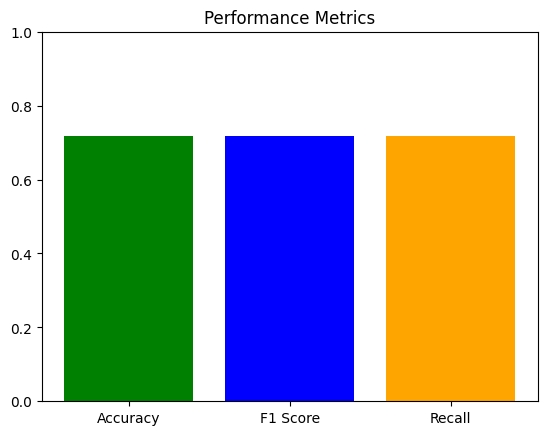

In [19]:
import matplotlib.pyplot as plt

# plot the metrics
labels = ['Accuracy', 'F1 Score', 'Recall']
scores = [accuracy, f1, recall]
colors = ['green', 'blue', 'orange']
plt.bar(labels, scores, color=colors)
plt.ylim(0, 1.0)
plt.title('Performance Metrics')
plt.show()